# Cat vs Dog

In [1]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import transforms , datasets , models
import torch.nn as nn
import torch.optim as optim
import os

### Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

Using Device: cpu


### Transformation

In [3]:
data_transform = {
    "train" : transforms.Compose([
        transforms.Resize((264 , 264)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485 , 0.456 , 0.406] , [0.229 , 0.224 , 0.225])
    ]),

    "test" : transforms.Compose([
        transforms.Resize((264 , 264)),
        transforms.ToTensor(),
        transforms.Normalize([0.485 , 0.456 , 0.406] , [0.229 , 0.224 , 0.225])
    ])
}

### Data Loading

In [4]:
data_dir = "./data"

train_data = datasets.ImageFolder(os.path.join(data_dir , "train") , transform=data_transform["train"])
test_data = datasets.ImageFolder(os.path.join(data_dir , "test") , transform=data_transform["test"])

train_loader = DataLoader(
    train_data,
    shuffle=True,
    batch_size=64
)

test_loader = DataLoader(
    test_data,
    shuffle=False,
    batch_size=64
)

### Pretrained Model

In [5]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_feature = model.fc.in_features
model.fc = nn.Linear(num_feature , 2)
model = model.to(device)

c:\Users\shkus\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\shkus\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Loss & Optimizers

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters() , lr=0.001)

### Training Loops

In [ ]:
epochs = 10
train_losses = []
test_accuracy = []
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images , labels in train_loader:
        images , labels = images.to(device) , labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output , labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    average_loss = running_loss / len(train_loader)

    train_losses.append(average_loss)

    model.eval()
    correct = 0 
    total = 0
    with torch.no_grad():
        for images , labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            predicted = torch.argmax(output , dim=1)
            correct += (predicted == labels).sum().item()
            total = labels.size(0)
        accuracy = correct / total
        test_accuracy.append(accuracy)
    print(f"Epoch: {epoch+1}/{epochs} | Loss: {average_loss:.2f} | Accuracy: {accuracy * 100}%")


Epoch: 1/1 | Loss: 0.11 | Accuracy: 5105.128205128205%


### Image Prediction

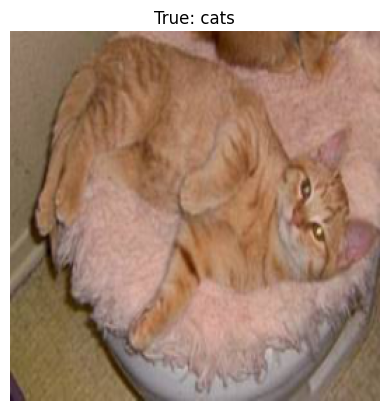

Index 890 | True: cats | Predicted: cats


In [14]:
classes = train_data.classes
index = 890
image , true_labels = test_data[index]
img = image.clone()
img = img * torch.tensor([0.229,0.224,0.225]).view(3,1,1) + torch.tensor([0.485,0.456,0.406]).view(3,1,1)
img = torch.clamp(img , 0 , 1)

plt.imshow(img.permute(1, 2, 0))
plt.title(f"True: {classes[true_labels]}")
plt.axis("off")
plt.show()


# Evalutaion
model.eval()
with torch.no_grad():
    image = image.unsqueeze(0).to(device)
    output = model(image)
    prediction = torch.argmax(output , dim=1).item()
    print(f"Index {index} | True: {classes[true_labels]} | Predicted: {classes[prediction]}")
